# Twitter Sentiment Label Prediction with PCA and Logistic Regression
John Bonfardeci 2020-04-13

In [16]:
import pandas as pd
import re
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import PCA
import math
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns

## Helper Functions

In [13]:
stop_words = pd.read_csv('data/stopwords.csv').values

def get_cm(actual, predicted):
    df = pd.DataFrame()
    df['Actual'] = actual
    df['Yhat'] = predicted
    vals = df.values
    dat = pd.DataFrame(columns=['TP', 'TN', 'FP', 'FN'], data=[])
    dat['TP'] = list(map(lambda y: 1 if y[0] == y[1] and y[0] == True else 0, vals))
    dat['TN'] = list(map(lambda y: 1 if y[0] == y[1] and y[0] == False else 0, vals))
    dat['FP'] = list(map(lambda y: 1 if y[0] != y[1] and y[0] == False else 0, vals))
    dat['FN'] = list(map(lambda y: 1 if y[0] != y[1] and y[0] == True else 0, vals))
    tp = sum(dat['TP'])
    tn = sum(dat['TN'])
    fp = sum(dat['FP'])
    fn = sum(dat['FN'])
    tpr = tp/(tp+fn)
    tnr = tn/(tn+fp)
    stats = pd.DataFrame(columns=['TP', 'FP', 'TN', 'FN', 'Sensitivity', 'Specificity'],
                data=[[tp, fp, tn, fn, tpr, tnr]])
    return stats

def get_ba(dat):
    cm = get_cm(dat).values.tolist()[0]
    sens = float(cm[4])
    spec = float(cm[5])
    return (sens+spec)/2

def get_roc(actual, predicted, title="ROC"):
    """
    Plot ROC curve based on actuals and estimated probabilities.
    """
    fpr, tpr, threshold = roc_curve(actual, predicted)    
    roc_auc = auc(fpr, tpr)
    plt.title(title)
    lbl = 'AUC: {0:.3f}'.format(roc_auc)
    plt.plot(fpr, tpr, 'b', label = lbl)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()  
        
def clean(s):
        s = s.lower()
        s = re.sub("^\@\w+\s+", "", s) # remove tweeter name (e.g. "@elephantbird ")
        s = re.sub("(^\s+|\s+$)", "", s) # trim leading/trailing spaces
        s = re.sub("[^a-z]", " ", s) # remove all but letters and spaces
        w = [w for w in s.split(' ') if w not in stop_words]         
        return ' '.join(w)
    
def plot_scree(percent_variance):
    """
    Create Scree Plot of Principal Components Variance
    """  
    # Visualize the variance explained for each observation by the principal components
    cols = []
    for i in range(len(percent_variance)):
        cols.append('PC'+str(i+1))

    sns.barplot(y=cols, x=percent_variance)
    plt.title('PCA Scree Plot - larger explains more variance')
    plt.show()

### Import Twitter Dataset

In [5]:
filepath = 'data/twitter_dataset.csv'
df = pd.read_csv(filepath)
df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


### Clean the text
Remove usernames, punctuation, convert lowercase.

In [7]:
# Clean the text
col_name = "tweet_text"
target_col = "sentiment_label"
# Replace punctuation, special characters and digits with space
sentiment = df[col_name].values
df[col_name] = list( map(clean, sentiment) )
df.head()

,sentiment_label,tweet_text
0,4,hey dear happy friday rice s bowl lunch
1,4,ughhh layin downnnn waiting zeina cook brea...
2,0,reckon ll play s know won t
3,0,know saw news
4,0,sad http www fabchannel com closed web ser...


## Hash Features

In [39]:
hasher = HashingVectorizer(n_features=2**12)
hash_vector = hasher.transform( df[col_name].values ).toarray()
len(hash_vector[0])

4096

## Convert to Principal Components

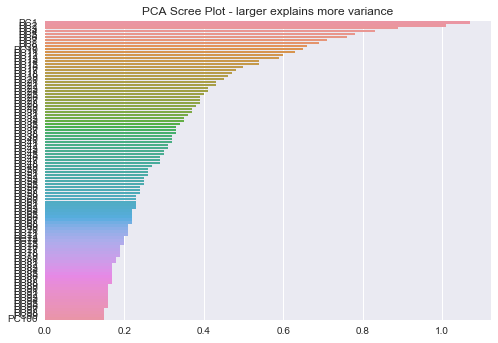

In [40]:
pca = PCA(n_components=100, random_state=123)
pc = pca.fit_transform(hash_vector)

percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals=2)
plot_scree(percent_variance)

## Logistic Regression

In [41]:
# Split data into 70/30 Train/Validation sets
y = list( map(lambda x: 0 if x == 0 else 1, df[target_col].values) )
X_train, X_test, y_train, y_test = train_test_split(pc, y, test_size=0.3, random_state=123)

In [42]:
logit = LogisticRegression(random_state=123)
logit.fit(X_train, y_train)
predicted = logit.predict(X_test)

In [43]:
stats = get_cm(y_test, predicted)
stats.head()

,TP,FP,TN,FN,Sensitivity,Specificity
0,15147,6539,17367,8947,0.628663,0.72647
